In [1]:
from pathlib import Path
from os.path import expanduser
from os import path
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os

In [2]:
max_dataset_size = 6000000
waveform_length = 72;
nb_of_elements = 100000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
root_folder = os.path.dirname(os.getcwd())
path_to_recording= path.join(root_folder,'data/single_channel_data.npy');
path_to_ground_truth_data = path.join(root_folder,'data/single_channel_spike_train.npy');
path_to_train_data = path.join(root_folder,'data/train_data.npy');
path_to_train_labels = path.join(root_folder,'data/train_labels.npy');
path_to_noise_data = path.join(root_folder,'data/noise_data.npy');
path_to_mean_std = path.join(root_folder,'data/mean_std.npy');
sys.path.append(root_folder)
from custom_resnet import CustomResnet as cnn

In [4]:
noise_indices = cnn.GetNoiseIndices(path_to_recording, path_to_ground_truth_data, waveform_length, nb_of_elements);



In [5]:
noise_class = torch.zeros(1, noise_indices.nelement(), dtype= torch.int);
noise_data = torch.cat((noise_indices, noise_class), 0);


In [6]:
np.save(path_to_noise_data, noise_data.numpy());

In [7]:
dataset_spikes = cnn.GenerateDataset(path_to_recording, path_to_ground_truth_data, waveform_length, max_dataset_size);


========== 1 generation ==========
temp_dataset_len:  0
shift_from:  -18
shift_to:  19
shift_step:  4
shift_indexes:  tensor([-18, -14, -10,  -6,  -2,   2,   6,  10,  14,  18], dtype=torch.int32)
snr_ratio:  None
flip_data 2


/home/vtpc/Documents/Alvils/spike-sorting/custom_resnet/CustomResnet.py:291: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  temp = temp.new_tensor(data);


temp_dataset_len_after:  0 369100
temp_dataset_len_after:  1 738200
dataset len:  1 738200
========== 2 generation ==========
temp_dataset_len:  0
shift_from:  -14
shift_to:  5
shift_step:  4
shift_indexes:  tensor([-14, -10,  -6,  -2,   2], dtype=torch.int32)
snr_ratio:  14.725915947409174
flip_data 2
temp_dataset_len_after:  0 184550
temp_dataset_len_after:  1 369100
dataset len:  1 1107300
========== 3 generation ==========
temp_dataset_len:  0
shift_from:  -17
shift_to:  18
shift_step:  1
shift_indexes:  tensor([-17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,
         -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
         11,  12,  13,  14,  15,  16,  17], dtype=torch.int32)
snr_ratio:  13.219228750849387
flip_data 1
temp_dataset_len_after:  0 1291850
dataset len:  0 2399150
========== 4 generation ==========
temp_dataset_len:  0
shift_from:  -13
shift_to:  12
shift_step:  2
shift_indexes:  tensor([-13, -11,  -9,  -7,  -5,  -3,  -1,   1,

In [8]:
dataset_noise = cnn.GenerateDataset(path_to_recording, path_to_noise_data, waveform_length, max_dataset_size);


========== 1 generation ==========
temp_dataset_len:  0
shift_from:  -18
shift_to:  19
shift_step:  4
shift_indexes:  tensor([-18, -14, -10,  -6,  -2,   2,   6,  10,  14,  18], dtype=torch.int32)
snr_ratio:  None
flip_data 2
temp_dataset_len_after:  0 1000000
temp_dataset_len_after:  1 2000000
dataset len:  1 2000000
========== 2 generation ==========
temp_dataset_len:  0
shift_from:  -2
shift_to:  1
shift_step:  4
shift_indexes:  tensor([-2], dtype=torch.int32)
snr_ratio:  6.297774501230192
flip_data 2
temp_dataset_len_after:  0 100000
temp_dataset_len_after:  1 200000
dataset len:  1 2200000
========== 3 generation ==========
temp_dataset_len:  0
shift_from:  -2
shift_to:  5
shift_step:  3
shift_indexes:  tensor([-2,  1,  4], dtype=torch.int32)
snr_ratio:  13.30160465387763
flip_data 2
temp_dataset_len_after:  0 300000
temp_dataset_len_after:  1 600000
dataset len:  1 2800000
========== 4 generation ==========
temp_dataset_len:  0
shift_from:  -2
shift_to:  15
shift_step:  4
shift_in

In [9]:
dataset_size =  dataset_spikes.__len__() if dataset_spikes.__len__() < dataset_noise.__len__() else  dataset_noise.__len__()

In [10]:
# convers to np array
np_data_spikes = np.zeros((dataset_size, 1, waveform_length));
for i, (data, target) in enumerate(dataset_spikes):
  np_data_spikes[i, :] = data.numpy();
  if(i + 1 == dataset_size):
    break;
    
del dataset_spikes

# removes spikes that have mutiple spikes in waveform
spike_argmax = np.argmax(np_data_spikes, 2)
over_treshold = waveform_length // 2 + waveform_length // 4
under_treshold = waveform_length // 2 - waveform_length // 4
is_valid_train_data = ((spike_argmax >= under_treshold) & (spike_argmax <= over_treshold)).ravel()
np_data_spikes = np_data_spikes[is_valid_train_data, :, :]
dataset_size = np_data_spikes.shape[0]
np_classes_spikes = np.ones(dataset_size)


np_data_noise = np.zeros((dataset_size, 1, waveform_length));
np_classes_noise = np.zeros(dataset_size)
for i, (data, target) in enumerate(dataset_noise):
  np_data_noise[i, :] = data.numpy();
  if(i + 1 == dataset_size):
    break;
    
del dataset_noise

    


In [11]:
np_data_noise.shape

(6111952, 1, 72)

In [12]:
dataset = np.concatenate((np_data_spikes, np_data_noise), 0);

In [13]:
labels = np.concatenate((np_classes_spikes, np_classes_noise), 0); 

In [14]:
np.save(path_to_train_data, dataset)
np.save(path_to_train_labels, labels)


In [15]:
mean = (np.mean(np_data_spikes))
std = (np.std(np_data_spikes))
np.save(path_to_mean_std, [mean, std])

print(mean)
print(std)

0.10000542904712027
0.41506710104839384


21

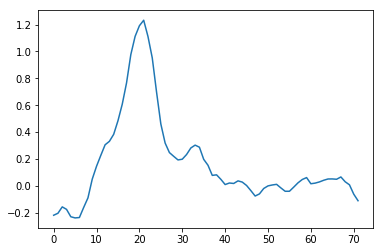

In [16]:
import matplotlib.pyplot as plt
rnd = np.random.randint(0, dataset_size);
plt.plot(np_data_spikes[rnd, 0, :])
np.argmax(np_data_spikes[rnd, 0, :])